In [2]:
import matplotlib.pyplot as plt
from time import time
import perfplot
import numpy as np
import networkx as nx
import igraph as ig
from tqdm import tqdm

### Setup

In [127]:
def nn_copy(X, n):
    X = np.array(X)
    return np.tile(X, tuple([n for i in range(len(X.shape))])) 

def binc(s):
    s = s.replace('f','F')
    s = s.replace('t','T')
    return np.array(eval(s)).astype(int)

binc('''[[false,true,false], 
 [false,false,false], 
 [true,false,false]]''')

array([[0, 1, 0],
       [0, 0, 0],
       [1, 0, 0]])

1. **Trying to implement multiple subplots of perplot**. Given adjacency matrix of a graph, check if it has the same amount of incoming and outcoming nodes.

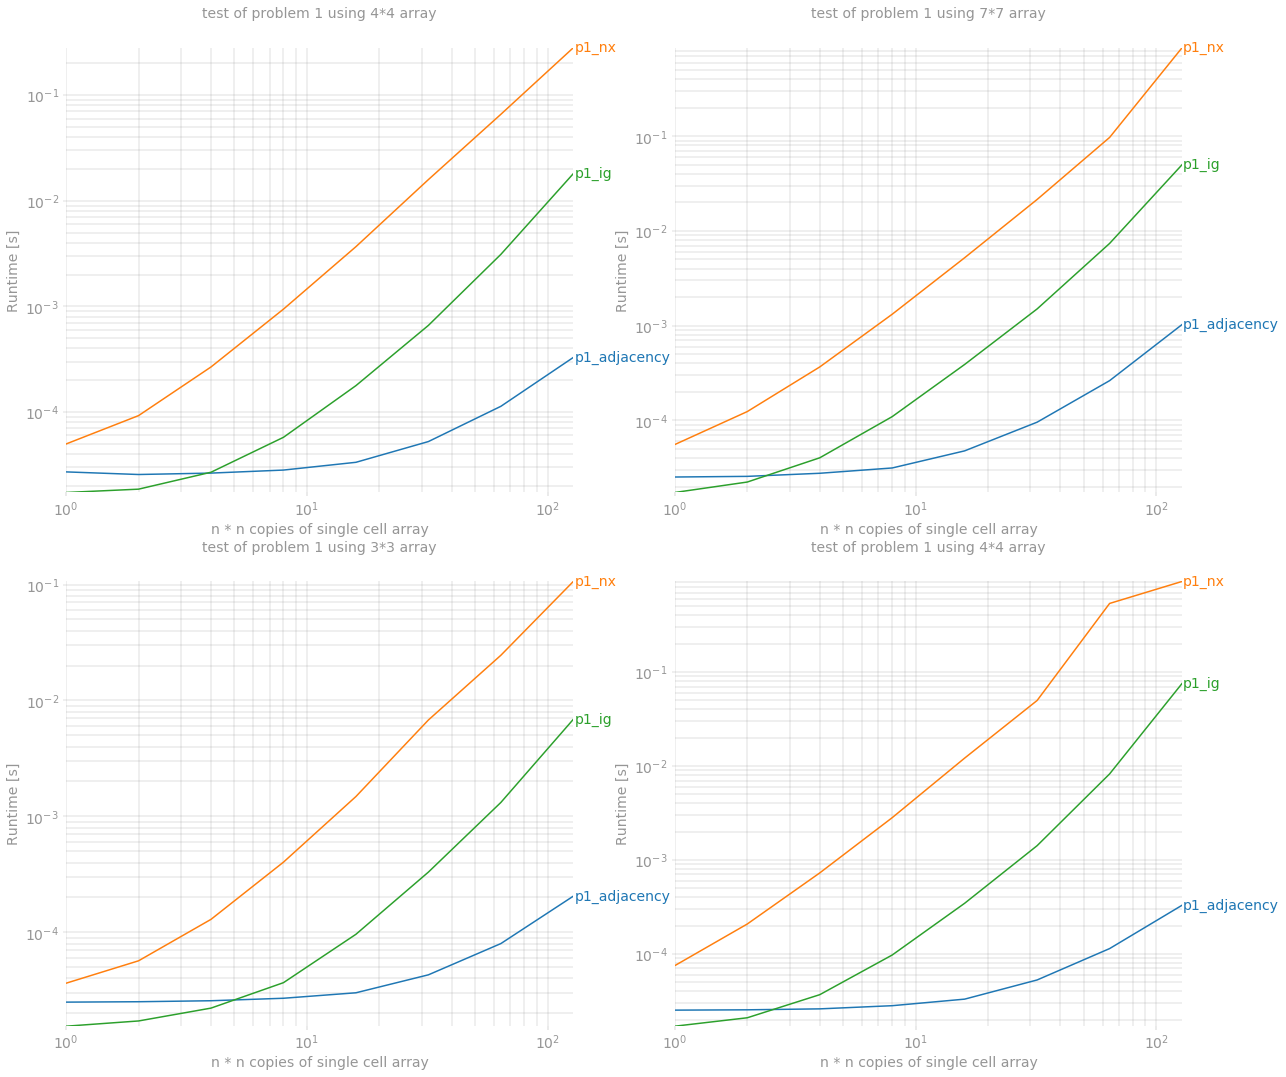

Overall testing time: 99.82076287269592


In [133]:
def p1_adjacency(X):
    x = np.array_equal(np.sum(X, axis=0), np.sum(X, axis=1))
    return x

def p1_ig(X):
    g = ig.Graph.Adjacency(X.tolist())
    return g.indegree() == g.outdegree()

def p1_nx(X):
    G = nx.from_numpy_matrix(X, create_using=nx.DiGraph())
    return list(G.in_degree()) == list(G.out_degree())

def setup(X, n):
    #print(n)
    return nn_copy(X, n)

def build_args(X):
    X = np.array(X)
    base = round(np.log(X.shape[0]) / np.log(2))
    return {'setup': lambda n: setup(X, n),
    'kernels': [p1_adjacency, p1_nx, p1_ig],
    'n_range': [2 ** (k-base) for k in range(base, base + 8)],
     'xlabel': "n * n copies of single cell array",
     'title' : f'test of problem 1 using {X.shape[0]}*{X.shape[1]} array',
     'show_progress':False}
    
    
t = time()
outs = [perfplot.bench(**build_args(n)) for n in 
        ([[0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], [0, 0, 1, 0]],
         [[0, 1, 0, 0, 0, 0, 0],[1, 0, 0, 0, 0, 0, 0],[0, 0, 0, 1, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0]],
         [[0, 1, 0], [0, 0, 0], [1, 0, 0]],
         [[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]])]
         
fig = plt.figure(figsize=(20, 20))
for i in range(len(outs)):
    ax = fig.add_subplot(2, 2, i+1)
    ax.grid(True, which="both")
    outs[i].plot()
plt.show()
print('Overall testing time:', time()-t)

2. Given edges of graph and total number of nodes, find edges of its complement graph.

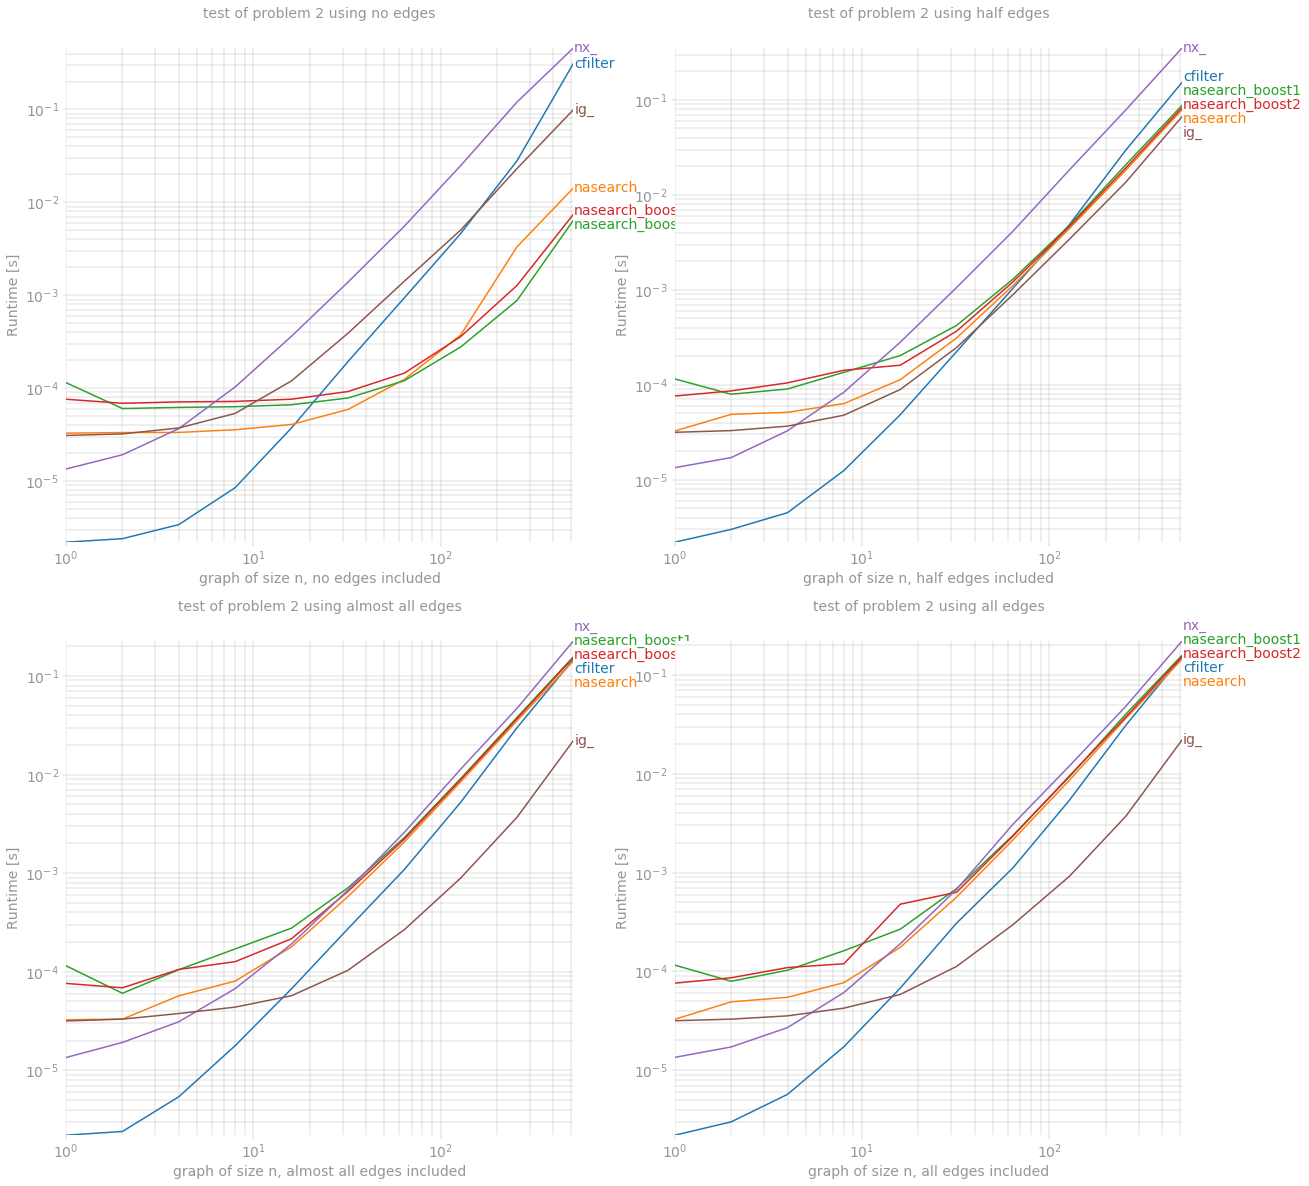

Overall testing time: 238.33738112449646


In [3]:
from itertools import combinations

def cfilter(data):
    n, edges = data
    complete_ways = set(combinations(range(n),2))
    included_ways = set([tuple(sorted(n)) for n in edges])
    return sorted(complete_ways - included_ways)

def nasearch(data):
    n, edges = data
    Z = np.ones((n,n)).astype(bool)
    if edges:
        x, y = np.array(edges).T
        Z[x, y] = False
        Z[y, x] = False
    cx, cy = np.array(np.where(Z))
    mask = cx < cy
    return np.vstack([cx, cy]).T[mask]

def nasearch_boost1(data):
    n, edges = data
    if edges:
        edges = np.sort(np.array(edges), axis=1)
        edges_idx = n * edges[:,0] + edges[:,1]
    else:
        edges_idx = []
    square_idx = np.arange(n*n).reshape(n, n)
    upper_idx = square_idx[np.triu_indices(n, 1)]
    complement_mask = ~np.isin(upper_idx, edges_idx)
    complement_idx = upper_idx[complement_mask]
    return np.vstack(np.divmod(complement_idx, n)).T

def nasearch_boost2(data):
    n, edges = data
    if edges:
        edges = np.sort(np.array(edges), axis=1)
        edges_idx = n * edges[:,0] + edges[:,1]
    else:
        edges_idx = []
    e = np.arange(n*n)
    e_idx = np.setdiff1d(e[e%n > e//n], edges_idx)
    return np.vstack(np.divmod(e_idx, n)).T

def nx_(data):
    n, edges = data
    G = nx.Graph()
    G.add_nodes_from(range(n))
    G.add_edges_from(edges)
    return list(nx.complement(G).edges)

def ig_(data):
    n, edges = data
    g = ig.Graph()
    g.add_vertices(range(n))
    g.add_edges(edges)
    c = g.complementer() #can't disable loops...
    return sorted(e.tuple for e in c.es if e.source != e.target)

def setup(amount, n):
    if amount=='no': return (n, [])
    elif amount=='half': return (n, list(combinations(range(n), 2))[::2])
    elif amount=='almost all': return (n, list(combinations(range(n), 2))[:-1])
    else: return (n, list(combinations(range(n), 2)))

def build_args(amount):
    return {'setup': lambda n: setup(amount, n),
    'kernels': [cfilter, nasearch, nasearch_boost1, nasearch_boost2, nx_, ig_],
    'n_range': [2 ** k for k in range(10)],
     'xlabel': f'graph of size n, {amount} edges included',
     'title' : f'test of problem 2 using {amount} edges',
     'show_progress': False,
     'equality_check': lambda x, y: np.array_equal(list(x), list(y))}
    
    
t = time()
outs = [perfplot.bench(**build_args(n)) for n in ('no','half','almost all','all')]
         
fig = plt.figure(figsize=(20, 20))
for i in range(len(outs)):
    ax = fig.add_subplot(2, 2, i+1)
    ax.grid(True, which="both")
    outs[i].plot()
plt.show()
print('Overall testing time:', time()-t)

2. Identify pairs of combinations of `range(n)`

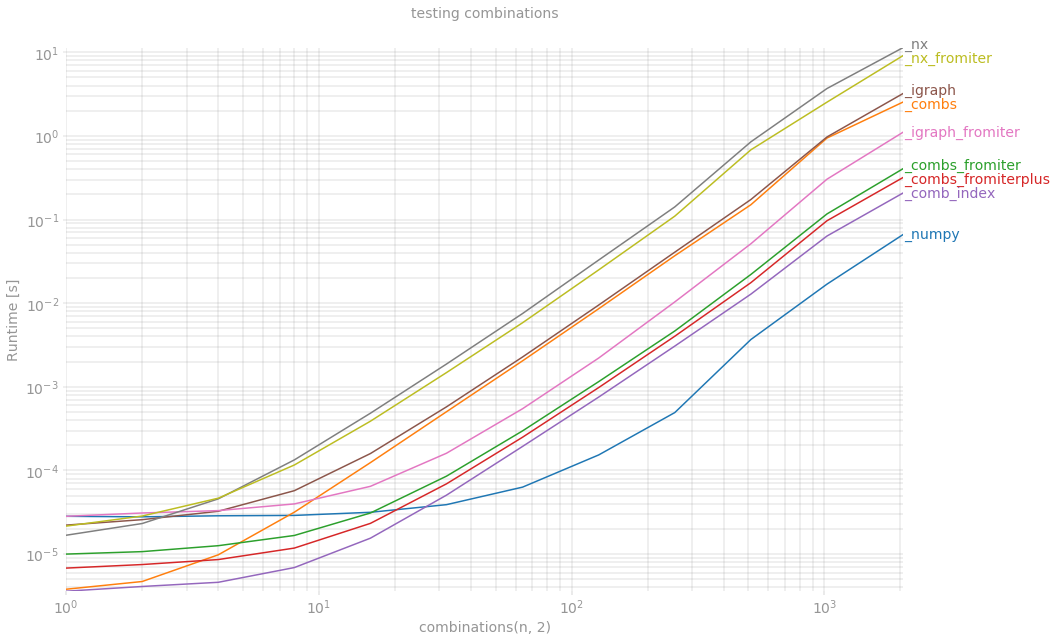

Total time of tests: 113.486


In [48]:
from itertools import combinations, chain
from scipy.special import comb
from time import*

def _combs(n):
    return np.array(list(combinations(range(n),2)))

def _combs_fromiter(n): #@Jaime
    indices = np.arange(n)
    dt = np.dtype([('', np.intp)]*2)
    indices = np.fromiter(combinations(indices, 2), dt)
    indices = indices.view(np.intp).reshape(-1, 2)
    return indices

def _combs_fromiterplus(n):
    dt = np.dtype([('', np.intp)]*2)
    indices = np.fromiter(combinations(range(n), 2), dt)
    indices = indices.view(np.intp).reshape(-1, 2)
    return indices

def _numpy(n): #@endolith
    return np.transpose(np.triu_indices(n,1))

def _igraph(n):
    return np.array(ig.Graph(n).complementer(False).get_edgelist())

def _igraph_fromiter(n):
    dt = np.dtype([('', np.intp)]*2)
    indices = np.fromiter(ig.Graph(n).complementer(False).get_edgelist(), dt)
    indices = indices.view(np.intp).reshape(-1, 2)
    return indices
    
def _nx(n):
    G = nx.Graph()
    G.add_nodes_from(range(n))
    return np.array(list(nx.complement(G).edges))

def _nx_fromiter(n):
    G = nx.Graph()
    G.add_nodes_from(range(n))
    dt = np.dtype([('', np.intp)]*2)
    indices = np.fromiter(nx.complement(G).edges, dt)
    indices = indices.view(np.intp).reshape(-1, 2)
    return indices

def _comb_index(n): #@HYRY
    count = comb(n, 2, exact=True)
    index = np.fromiter(chain.from_iterable(combinations(range(n), 2)), 
                        int, count=count*2)
    return index.reshape(-1, 2)

        
fig = plt.figure(figsize=(15, 10))
plt.grid(True, which="both")
out = perfplot.bench(
        setup = lambda x: x,
        kernels = [_numpy, _combs, _combs_fromiter, _combs_fromiterplus, 
                   _comb_index, _igraph, _igraph_fromiter, _nx, _nx_fromiter],
        n_range = [2 ** k for k in range(12)],
        xlabel = 'combinations(n, 2)',
        title = 'testing combinations',
        show_progress = False,
        equality_check = False)
out.show()
out.save('combinations.png', transparent=True, bbox_inches="tight")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.48s/it]


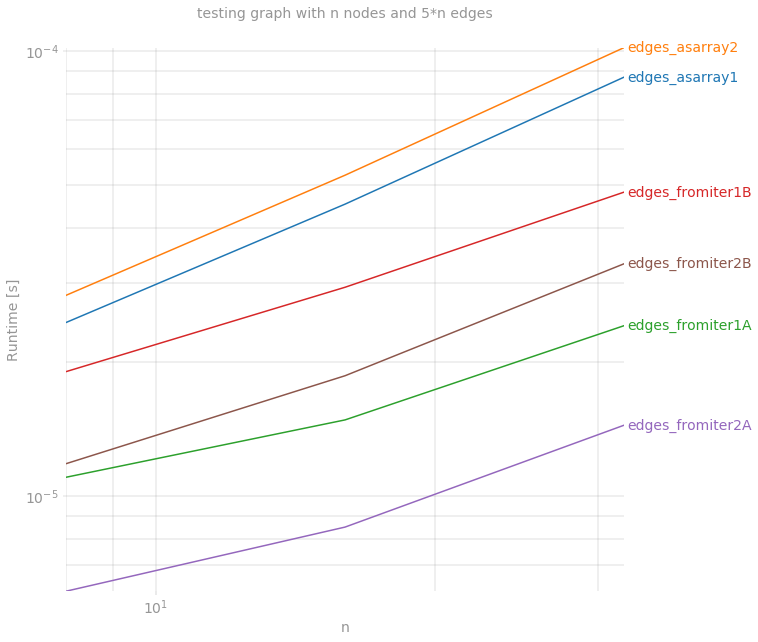

In [106]:
import igraph
import numpy as np
from itertools import chain

def edges_asarray1(g):
    return np.array(g.get_edgelist())

def edges_asarray2(g):
    return np.array([n.tuple for n in g.es])

def edges_fromiter1A(g):
    dt = np.dtype([('', np.intp)]*2)
    indices = np.fromiter(g.get_edgelist(), dt)
    indices = indices.view(np.intp).reshape(-1, 2)
    return indices

def edges_fromiter1B(g):
    index = np.fromiter(chain(*g.get_edgelist()), np.dtype('i'), count=g.ecount())
    return index.reshape(-1, 2)
fig = plt.figure(figsize=(10, 10))

def edges_fromiter2A(g):
    dt = np.dtype([('', np.intp)]*2)
    indices = np.fromiter(map(lambda x: x.tuple, g.es), dt)
    indices = indices.view(np.intp).reshape(-1, 2)
    return indices

def edges_fromiter2B(g):
    index = np.fromiter(chain(*map(lambda x: x.tuple, g.es)), np.dtype('i'), count=g.ecount())
    return index.reshape(-1, 2)

plt.grid(True, which="both")
def f(x):
    print(x)
    return x
out = perfplot.bench(
        setup = lambda x: ig.Graph.Erdos_Renyi(n=x, m=int(2.5*x)),
        kernels = [edges_asarray1, edges_asarray2, edges_fromiter1A, edges_fromiter1B, edges_fromiter2A, edges_fromiter2B],
        n_range = [2 ** k for k in range(3, 9)],
        xlabel = 'n',
        title = 'testing graph with n nodes and 5*n edges',
        show_progress = False,
        equality_check = False)
out.show()